In [1]:
# 使用networkx包进行图数据结构的处理
# 使用matplotlib包进行图像化展示
# 使用graphviz进行图像绘制

import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz


In [2]:
# 从txt文件中导入线路信息
# txt文件格式：线路代码 线路名称 线路颜色 
# 示例："8 东铁线 #74B4E0"
# lines_info_txt为txt文件路径，line_name_index为线路名称信息索引号，with_color为是否读取线路颜色信息，line_color_index为线路颜色信息索引号，default_color为默认线路颜色

def get_lines_info_from_txt(lines_info_txt, line_name_index = 1, with_color = True, line_color_index = 2, default_color = "black", code = "utf-8"):
    Lines = list()

    with open(lines_info_txt, "rt", encoding = code) as txt:
        Lines_txt = txt.readlines()
        for line in Lines_txt:
            if line[0] != "#":    # txt文件中，使用#开头表示注释
                if with_color:    # txt文件中包含线路颜色信息的情况
                    Lines.append([line.split()[line_name_index], line.split()[line_color_index]])
                else:    # txt文件中不包含线路颜色信息时，使用黑色作为默认颜色
                    Lines.append([line.split()[line_name_index], default_color])
        return Lines


In [3]:
# 从txt文件中导入站与站间的连接信息
# txt文件格式
# 编号 站I 站II 距离 线路代码
# 示例："72 上水 粉岭 1.500 8"
# routes_info_txt为txt文件路径，station_index为站点索引号，with_destination为是否读取距离信息，destination_index为距离信息索引号
# with_line为是否读取线路信息，line_number为线路总数，line_index为线路信息索引号

def get_routes_info_from_txt(routes_info_txt, station_index = [1, 2], with_destination = True, destination_index = 3, with_line = True, line_number = 1, line_index = 4, code = "utf-8"):
    Routes = list()

    for i in range(line_number):
        Routes.append(list())    # 使用数组表示不同的线路内站与站的连接。如不指定线路，则默认设置为只有一条线路。

    with open(routes_info_txt, "rt", encoding = code) as txt:
        Routes_txt = txt.readlines()
        for route in Routes_txt:
            if route[0] != "#":    # txt文件中，使用#开头表示注释
                if with_destination:    # 读取txt文件中的距离信息
                    weight = eval(route.split()[destination_index])
                else:    # 如txt文件中无距离信息，默认设置为1
                    weight = 1
                if with_line:    # 读取txt文件中的线路信息
                    line = eval(route.split()[line_index])
                else:
                    line = 0    # 如txt文件中无线路信息，则默认设置为只有一条线路。
                Routes[line].append([route.split()[station_index[0]], route.split()[station_index[1]], weight])
        return Routes


In [4]:
# 获取换乘站列表
# Route_map为线路图变量，include_final表示是否包括端点站

def get_transit_stations(Route_map, include_final = True):
    Transit_stations = list()

    for station in Route_map.nodes():
        if len(Route_map[station]) == 1 and include_final == True:    # 对于端点站，度超过1的站为换乘站
            if Route_map.degree[station] > 1:
                Transit_stations.append(station)
        else:
            if Route_map.degree[station] > 2:    # 对于非端点站，度超过2的站为换乘站
                Transit_stations.append(station)
    return Transit_stations

In [5]:
# 从港铁信息文件构建线路与连接信息列表

Lines = get_lines_info_from_txt("Hong_Kong_Metro_Lines_ZHCN.txt", code = "utf-16")    # 由于存在utf-8不支持的字符，此处采用utf-16编码
Routes = get_routes_info_from_txt("Hong_Kong_Metro_Routes_ZHCN.txt", line_number = len(Lines), code = "utf-16")    # 由于存在utf-8不支持的字符，此处采用utf-16编码


In [6]:
# 构建图数据结构

Map = nx.MultiGraph()    # 由于存在共线路线，此处采取多重图

for line in Routes:
    for route in line:
        Map.add_edge(route[0], route[1], weight = route[2])    # 有权无长度图的构建
        # Map.add_edge(route[0], route[1], len = route[2], weight = route[2])    # 有权有长度图的构建，可于绘图时考虑距离（但会增大绘图难度）


In [7]:
# 获取换乘站列表

Transit_stations = get_transit_stations(Map)

# 共线路径信息，此处手动填写，后期可编写函数自动获取

Overlap_routes = [("太子", "旺角"), ("旺角", "油麻地"), ("油塘", "调景岭"), ("北角", "鲗鱼涌"), ("中环/香港", "金钟"), ("中环/香港", "九龙")]


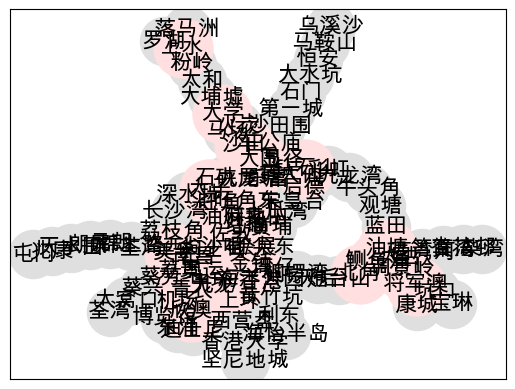

<Figure size 90000x90000 with 0 Axes>

In [8]:
# 绘图

station_color = "#DFDFDF"    # 站点颜色
station_size = 1200    # 站点节点大小
transit_station_color = "#FFDFDF"    # 换乘站点颜色
transit_station_size = 1800    # 换乘站点大小
label_color = "black"    # 标签颜色
label_size = 16    # 标签大小
line_width = 5    # 路线宽度
overlap_line_color = "black"    # 共线路线颜色
overlap_line_width = 8    # 共线路线宽度
figure_size = [30, 30, 3000]    # 图像大小于分辨率

plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]    # 设置字体允许中文显示

pos = nx.drawing.nx_agraph.graphviz_layout(Map, prog = "neato")    # 使用graphviz自动获取站点位置，亦可自行指定

nx.draw_networkx_nodes(Map, pos, node_color = station_color, node_size = station_size)    # 绘制站点
nx.draw_networkx_nodes(Map, pos, node_color = transit_station_color, node_size = transit_station_size, nodelist = Transit_stations)    # 绘制换乘站点
nx.draw_networkx_labels(Map, pos, font_color = label_color, font_size = label_size)    # 绘制标签


for i in range(len(Lines)):
    for route in Routes[i]:
        nx.draw_networkx_edges(Map, pos, edgelist = [(route[0], route[1])], width = line_width, edge_color = Lines[i][1])    # 绘制路线

nx.draw_networkx_edges(Map, pos, edgelist = Overlap_routes, width = overlap_line_width, edge_color = overlap_line_color)    # 绘制共线路线

plt.figure(figsize = (figure_size[0], figure_size[1]), dpi = figure_size[2])
plt.rcParams["figure.figsize"] = (figure_size[0], figure_size[1])
plt.show()


In [9]:
# 计算两站间最少站数路径及最短距离路径

Station_A = "油塘"
Station_B = "青衣"

shortest_path = nx.shortest_path(Map, source = Station_A, target = Station_B)    # 最少站数路径
dijkstra_path = nx.dijkstra_path(Map, source = Station_A, target = Station_B)    # 最短距离路径

print("最少站数 = ", len(shortest_path))
print("最少站数路径= ", str(shortest_path))
print("注：此路线距离为21.05\n")

print("最短距离 = " + str(nx.dijkstra_path_length(Map, source = Station_A, target = Station_B)))
print("此路线站数 = ", str(len(dijkstra_path)))
print("最短距离路径 = ", str(dijkstra_path))


最少站数 =  11
最少站数路径=  ['油塘', '鲗鱼涌', '北角', '炮台山', '天后', '铜锣湾', '湾仔', '金钟', '中环/香港', '九龙', '青衣']
注：此路线距离为21.05

最短距离 = 19.0
此路线站数 =  18
最短距离路径 =  ['油塘', '蓝田', '观塘', '牛头角', '九龙湾', '彩虹', '钻石山', '黄大仙', '乐富', '九龙塘', '石硖尾', '太子', '深水埗', '长沙湾', '荔枝角', '美孚', '荔景', '青衣']


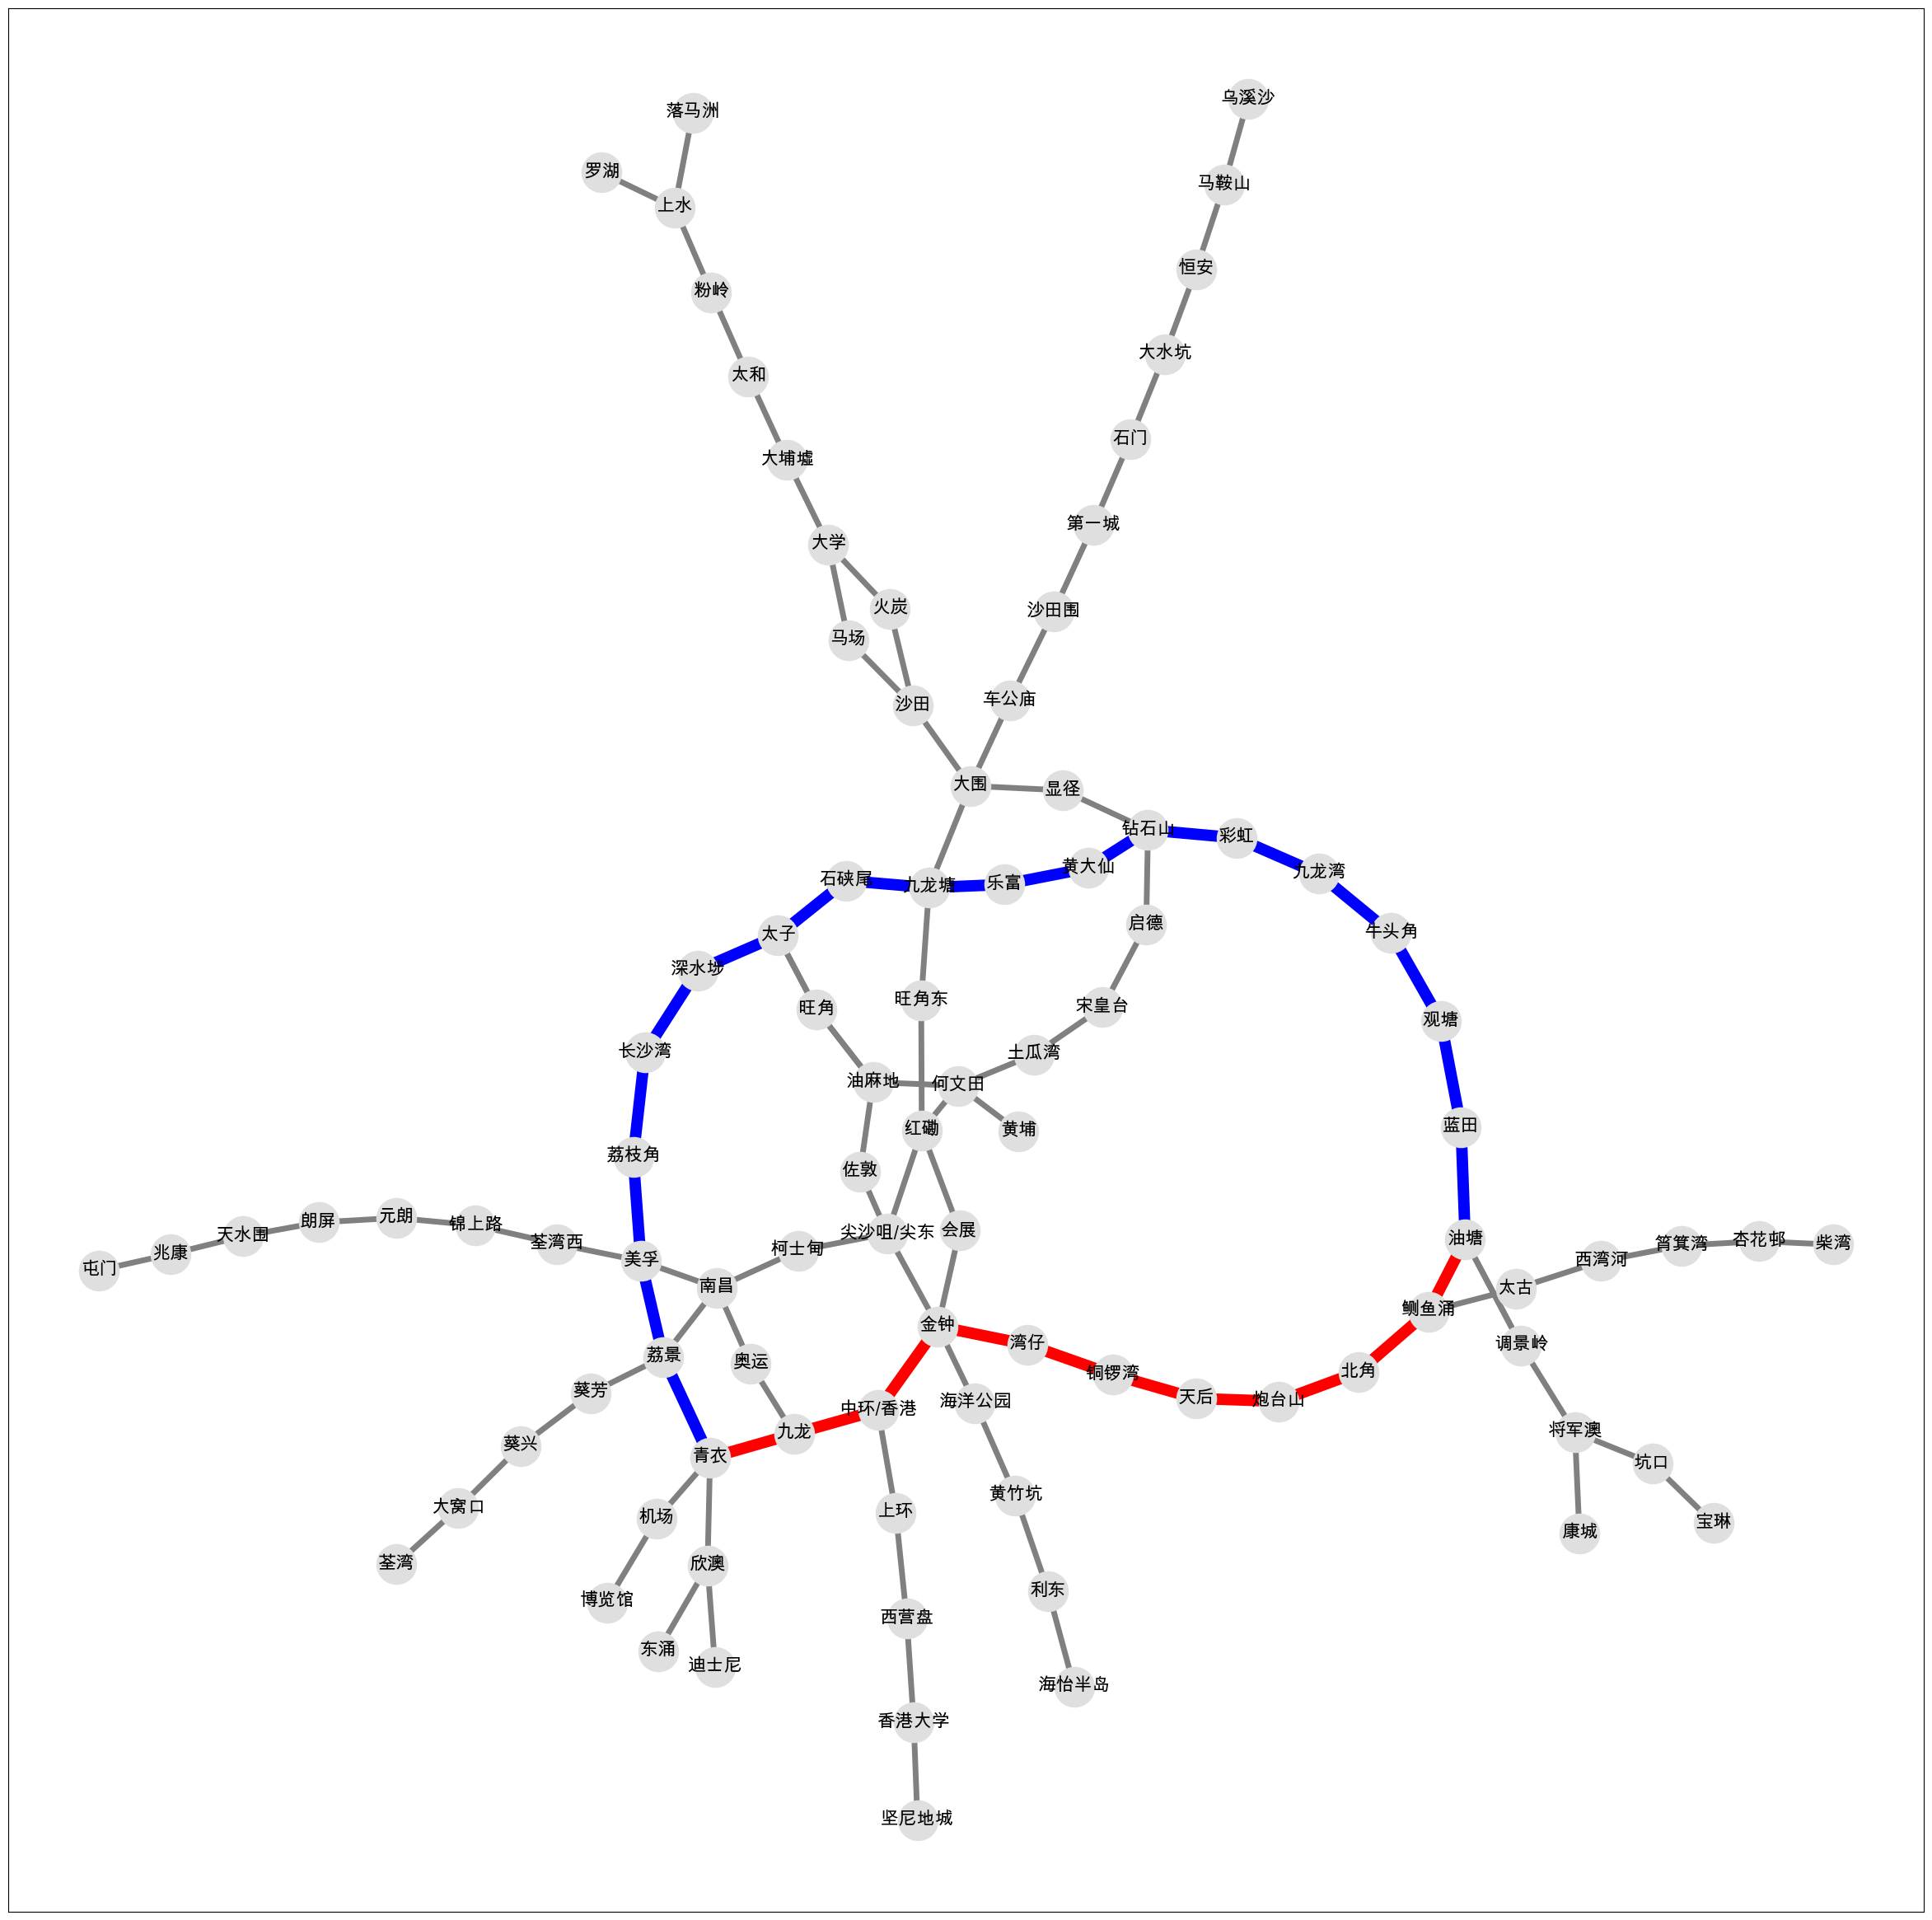

<Figure size 90000x90000 with 0 Axes>

In [10]:
# 作图示意
# 最少站数路径用红色表示
# 最短距离路径，用蓝色表示

plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]    # 设置字体允许中文显示
pos = nx.drawing.nx_agraph.graphviz_layout(Map, prog = "neato")    # 使用graphviz自动获取站点位置，亦可自行指定

nx.draw_networkx_nodes(Map, pos, node_color = station_color, node_size = station_size)    # 绘制站点
nx.draw_networkx_labels(Map, pos, font_color = label_color, font_size = label_size)    # 绘制标签

for i in range(len(Lines)):
    for route in Routes[i]:
        nx.draw_networkx_edges(Map, pos, edgelist = [(route[0], route[1])], width = line_width, edge_color = "grey")    # 绘制路线

path = shortest_path
path_edges = list(zip(path, path[1:]))
nx.draw_networkx_edges(Map, pos, edgelist = path_edges, edge_color = "red", width = 10)    # 绘制最少站数路径，用红色表示

path = dijkstra_path
path_edges = list(zip(path, path[1:]))
nx.draw_networkx_edges(Map, pos, edgelist = path_edges, edge_color = "blue", width = 10)    # 绘制最短距离路径，用蓝色表示

plt.figure(figsize = (figure_size[0], figure_size[1]), dpi = figure_size[2])
plt.rcParams["figure.figsize"] = (figure_size[0], figure_size[1])
plt.show()
